In [1]:
import numpy as np
import pandas as pd
import importlib
from scipy.optimize import fsolve
import iris
import iris.quickplot as qplt
import fourDEnVar_engine
import fourDEnVar_engine_gamma
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
importlib.reload(fourDEnVar_engine)
importlib.reload(fourDEnVar_engine_gamma)
import xarray as xr
from kneed import KneeLocator

def RMSE(array1, array2):
    rmsediff=(array1-array2)**2.0
    rmsemean=np.mean(rmsediff)
    rmse=rmsemean**0.5
        
    return rmse

In [2]:
filepath='/gws/nopw/j04/jules/ndouglas/FluxNet/u-dr501/da_files/'
parameter_names=['alpha_io','neff_io','omega_io','t_low','t_upp','g1_stomata_io']
obs_twin_index=11
site = 'US_Ha1'
obs = 'GPP'

#obs_tag='twin'
obs_tag='realobs'
ens_tag='_20'

OPTGAMMA=60

sigma=0.12

output_var='gpp_gb'
output_unit=r'kgm$^{-2}$s$^{-1}$'      
        
## DA features
Xb=np.load(filepath+'Xb'+ens_tag+'.npy')
nens=np.shape(Xb)[1]
true_params=Xb[:,obs_twin_index]
xbar=np.load(filepath+'xb'+ens_tag+'.npy')
## DA using cubes and different values of gamma
years=np.arange(1992,2010)

hxbar_cube=iris.load_cube(filepath+'hxbar_cube_'+site+'_'+obs+ens_tag+'.nc')
limited_hxbar=hxbar_cube.extract(iris.Constraint(year=years))

hX=[]
for i in range(0,nens):
    hX_cube=iris.load_cube(filepath+'hX_cube_'+site+'_'+obs+'_ens'+str(i)+ens_tag+'.nc')
    limited_hX=hX_cube.extract(iris.Constraint(year=years))
    hX.append(limited_hX.data)
    if i == obs_twin_index:
        if obs_tag=='twin':
            y_cube=hX_cube.copy()
        else:
            y_cube=iris.load_cube(filepath+'y_cube_'+site+'_'+obs+'.nc')

limited_y=y_cube.extract(iris.Constraint(year=years))

#Data Assimilation
obs_indices=np.isnan(limited_y.data)==False
hX=np.transpose(hX)
hX=hX[obs_indices]
y=limited_y.data[obs_indices]
hxbar=limited_hxbar.data[obs_indices]
R=sigma*np.diag(np.ones(len(y)))

In [8]:
## DA using cubes and different values of gamma

xDA=fourDEnVar_engine.fourDEnVar_engine(Xb, hX, y, R, hxbar)
xa_orig=xDA.xa_analytical
print('xa_orig', xa_orig)
Xa_orig=xDA.Xa_analytical

#np.save(filepath+'Xa_orig_'+obs_tag+'_'+site+'_'+obs+ens_tag+'_1992-2009.npy',Xa_orig.data)
#np.save(filepath+'xa_orig_'+obs_tag+'_'+site+'_'+obs+ens_tag+'_1992-2009.npy',xa_orig.data)
GAMMAVALS=[25,26,27,28,29,30,35,40,45,50,60,70,80,90,100,150,200,2000,10000,100000,1000000,10000000]

for gammaval in GAMMAVALS:
    print(gammaval)
    xDA=fourDEnVar_engine_gamma.fourDEnVar_engine_gamma(Xb, hX, y, R, hxbar,gammaval)
    xa_gamma=xDA.xa_analytical
    print(xa_gamma)
    Xa_gamma=xDA.Xa_analytical
    Ybdash=xDA.Yb_dash
    w=xDA.w

    #np.save(filepath+'xa_'+obs_tag+'_'+site+'_'+obs+ens_tag+'_gammaval'+str(gammaval)+'_1992-2009.npy',xa_gamma.data)
    if gammaval==OPTGAMMA:
    #    np.save(filepath+'Xa_'+obs_tag+'_'+site+'_'+obs+ens_tag+'_gammaval'+str(gammaval)+'_1992-2009.npy',Xa_gamma.data)
        xa_optgamma=xa_gamma
        Xa_optgamma=Xa_gamma


shape of Xb: (6, 20)
shape of hX: (216, 20)
shape of y: (216,)
shape of R: (216, 216)
shape of hxbar :(216,)
shape of X_dash_b: (6, 20)
shape of Y_dash_b: (216, 20)
Xbdash*inv(I+Ybdash^T*Rinv*Ybdash)*Xbdash^T is symmetric and all eigenvalues are positive
xa_orig [ 4.72411541e-02 -5.46521507e-03  1.21099234e-01  4.80818823e-01
  5.83362489e+01  4.32592800e+00]
25
[ 4.81857761e-02 -3.24352756e-04  1.23506544e-01  5.30307662e+00
  3.92272652e+01  4.30379445e+00]
26
[ 4.81125924e-02 -2.35817315e-04  1.23627578e-01  5.32327888e+00
  3.91555652e+01  4.30245318e+00]
27
[ 4.80409389e-02 -1.49520229e-04  1.23747332e-01  5.34185978e+00
  3.90889707e+01  4.30109037e+00]
28
[ 4.79707944e-02 -6.53325631e-05  1.23865810e-01  5.35898257e+00
  3.90269712e+01  4.29971167e+00]
29
[4.79021331e-02 1.68613504e-05 1.23983018e-01 5.37478993e+00
 3.89691217e+01 4.29832189e+00]
30
[4.78349258e-02 9.71658013e-05 1.24098958e-01 5.38940708e+00
 3.89150329e+01 4.29692522e+00]
35
[4.75195625e-02 4.73376231e-04 1.24

/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/iris/common/mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


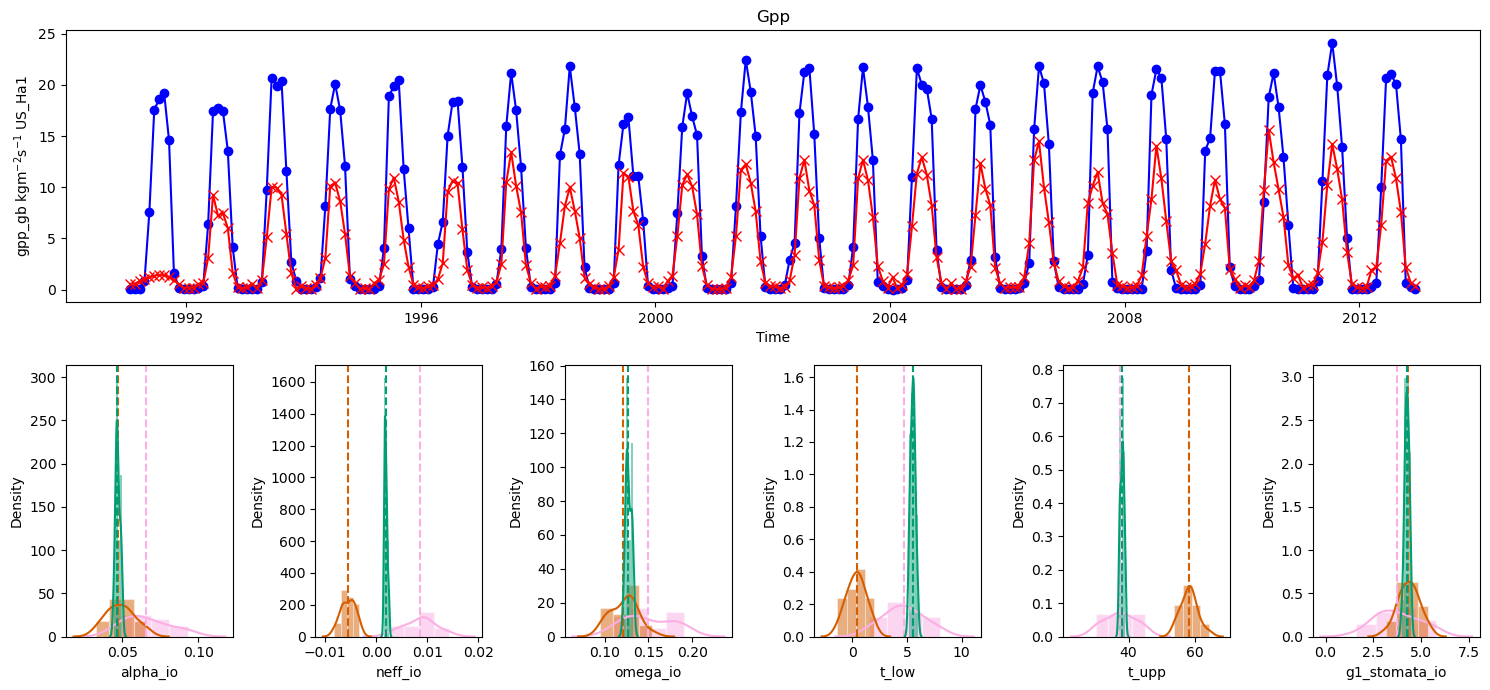

In [9]:
## Plots
fig = plt.figure(figsize=(15,7))
plt.subplot2grid((2,6),(0,0),colspan=6)
qplt.plot(hxbar_cube,'bo-',label='ensemble mean')
qplt.plot(y_cube,'rx-',label='observations', markersize=7)
#plt.plot(hX,'k',alpha=0.3)
plt.xlabel('Time')
plt.ylabel(output_var+' '+output_unit+' '+site)
#plt.legend()

weights = np.ones(nens) / float(nens)
palette=sns.color_palette("colorblind", 11)
for i in range(0,len(parameter_names)):
    plt.subplot2grid((2,len(parameter_names)),(1,i))
    sns.histplot(Xb[i,:], kde=True, color=palette[6], stat='density',kde_kws=dict(cut=3),edgecolor=(1, 1, 1, .4),bins=4,label='prior dist.')
    sns.histplot(Xa_orig[i,:], kde=True, color=palette[3], stat='density',kde_kws=dict(cut=3),edgecolor=(1, 1, 1, .4),bins=4,label='post. dist.')
    plt.axvline(xa_orig[i], color=palette[3], linestyle='--',label='post.')
    plt.axvline(xbar[i], color=palette[6], linestyle='--',label='prior mean')
    if obs_tag == 'twin':
        plt.axvline(true_params[i], color='g', linestyle='--',label='truth') 
    else:
        sns.histplot(Xa_optgamma[i,:], kde=True, color=palette[2], stat='density',kde_kws=dict(cut=3),edgecolor=(1, 1, 1, .4),bins=4,label='post. opt. gammadist.')
        plt.axvline(xa_optgamma[i], color=palette[2], linestyle='--',label='post. opt. gamma')
    plt.xlabel(parameter_names[i])
    #plt.legend()
    plt.tight_layout()
plt.tight_layout()

In [4]:
tracevals=[]
#gammavals=[0.01,0.1,1,10,100,1000,10000]
gammavals=[30,40,50,60,70,80,90,100,150,200,2000,10000,100000,1000000,10000000]
innov_norm=[]
innov_R_norm=[]
innov_norm_squared=[]
innov_R_norm_squared=[]
prior_norm=[]
prior_norm_squared=[]
GCV_score=[]
for gammaval in gammavals:
    xDA=fourDEnVar_engine_gamma.fourDEnVar_engine_gamma(Xb, hX, y, R, hxbar,gammaval)
    Ybdash=xDA.Yb_dash
    w=xDA.w
    
    prior_norm.append(np.sqrt(np.dot(w.T,w)))
    prior_norm_squared.append(np.dot(w.T,w))
    residual=limited_hxbar.data+np.dot(Ybdash,w)-limited_y.data
    innov_norm_squared.append(np.dot(residual.T,residual))
    innov_norm.append(np.sqrt(np.dot(residual.T,residual)))
    innov_R_norm_squared.append(np.dot(residual.T,np.dot(np.linalg.pinv(R),residual)))
    innov_R_norm.append(np.sqrt(np.dot(residual.T,np.dot(np.linalg.pinv(R),residual))))
    
    GCV_matrix=xDA.gcv_matrix
    GCVdenom=np.matrix.trace(np.identity(len(y))-GCV_matrix)**2
    print('gcv_denom',GCVdenom)
    GCV_yterm=np.dot(np.identity(len(y))-GCV_matrix,y)
    GCV=np.dot(GCV_yterm.T,np.dot(np.linalg.pinv(R),GCV_yterm))/GCVdenom
    #GCV=np.dot(GCV_yterm.T,GCV_yterm)/GCVdenom
    print(GCV)
    GCV_score.append(GCV)
    Pa=xDA.Pa
    tracevals.append(np.matrix.trace(Pa))


gcv_denom 44958.30748359992
0.05172347536389462
gcv_denom 45147.3567360492
0.05264286965486056
gcv_denom 45281.16204188268
0.05335610186901491
gcv_denom 45382.377690308065
0.0539337683102884
gcv_denom 45462.34762357164
0.05441517218391859
gcv_denom 45527.51264159642
0.05482482099247749
gcv_denom 45581.85716814407
0.05517916355104799
gcv_denom 45628.004594366335
0.05548981602153889
gcv_denom 45784.41458299845
0.05662416590945165
gcv_denom 45875.96981296731
0.057377308179987235
gcv_denom 46235.06302586415
0.07907959526903163
gcv_denom 46395.487363798675
0.2768795897571683
gcv_denom 46602.10840804754
1.0173809525616684
gcv_denom 46649.95148894719
1.2686880672591319
gcv_denom 46655.387641711626
1.2991302646126754


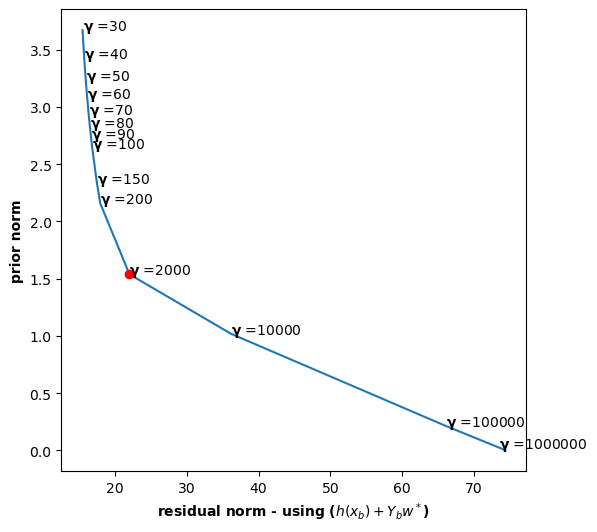

In [5]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
logit=False
if logit:
    ax1.plot(np.log(innov_norm),np.log(prior_norm),label='US_Ha1')
    ax1.set_xlabel('residual norm (log)',fontweight='bold')
    ax1.set_ylabel('prior norm (log)',fontweight='bold')
    for i in range(0,len(gammavals)):                                     # <--
        ax1.annotate(r'${\bf \gamma}$ =%s' % gammavals[i], xy=(np.log(innov_norm[i]),np.log(prior_norm[i])), textcoords='data') # <--
    kneedle1 = KneeLocator(np.log(innov_norm), np.log(prior_norm), curve='convex', direction='decreasing')
    ax1.plot(kneedle1.knee,np.log(prior_norm[np.where(np.log(innov_norm)==kneedle1.knee)[0][0]]),'ro')
    ax1.text(x=kneedle1.knee-0.1,y=np.log(prior_norm[np.where(np.log(innov_norm)==kneedle1.knee)[0][0]]-0.1),s='knee',color='red')
else:
    ax1.plot(innov_norm,prior_norm,label='US_Ha1')
    ax1.set_xlabel(r'residual norm - using ($h({x}_{{b}})+{ Y}_b{w^*}$)',fontweight='bold')
    ax1.set_ylabel('prior norm',fontweight='bold')
    for i in range(0,len(gammavals)-1):                                     # <--
        ax1.annotate(r'${\bf \gamma}$ =%s' % gammavals[i], xy=(innov_norm[i],prior_norm[i]), textcoords='data') # <--
    kneedle1 = KneeLocator(innov_norm, prior_norm, curve='convex', direction='decreasing')
    ax1.plot(kneedle1.knee,prior_norm[np.where(innov_norm==kneedle1.knee)[0][0]],'ro')

plt.savefig('/home/users/ndouglas/roses/u-dr501/bin/wTw.png')